<a href="https://colab.research.google.com/github/Ouvryy/69LaTrik/blob/main/MultiLayer_Perceptron_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_circles
import torch
from torch import nn
from torch.utils.data import DataLoader
from matplotlib.colors import ListedColormap

In [19]:
def get_device():
    """Return GPU device if available, or fall back to CPU"""

    return torch.device(
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )


device = get_device()
print(f"PyTorch {torch.__version__}, using {device} device")

PyTorch 2.6.0+cu124, using cpu device


In [20]:
# Hyperparameters
n_samples = 500  # Number of data samples
hidden_layer_dim = 3  # Number of neurons on the hidden layer of the MLP
n_epochs = 50  # Number of training iterations on the whole dataset
learning_rate = 0.1  # Rate of parameter change during gradient descent
batch_size = 5  # Number of samples used for one gradient descent step

In [21]:
# Generate 2D data (a large circle containing a smaller circle)
inputs, targets = make_circles(n_samples=n_samples, noise=0.1, factor=0.3)
print(f"Inputs: {inputs.shape}. targets: {targets.shape}")
assert inputs.shape == (n_samples, 2)
assert targets.shape == (n_samples,)

Inputs: (500, 2). targets: (500,)


In [22]:
# Convert inputs to a PyTorch tensor and put it on GPU memory (if available)
x_train = torch.from_numpy(inputs).float().to(device)
assert x_train.shape == torch.Size([n_samples, 2])

# Convert targets to a PyTorch tensor and put it on GPU memory (if available).
# PyTorch loss function expects float results of shape (batch_size, 1) instead of (batch_size,).
# So we add a new axis and convert them to floats
y_train = torch.from_numpy(targets[:, np.newaxis]).float().to(device)
assert y_train.shape == torch.Size([n_samples, 1])

In [23]:
# Create data loader for loading data as randomized batches
train_dataloader = DataLoader(
    list(zip(x_train, y_train)), batch_size=batch_size, shuffle=True
)

# Number of batches in an epoch (= n_samples / batch_size, rounded up)
n_batches = len(train_dataloader)
assert n_batches == math.ceil(n_samples / batch_size)

In [24]:
# Create a MultiLayer Perceptron with 2 inputs, a hidden layer and 1 output
model = nn.Sequential(
    # Hidden layer
    nn.Linear(in_features=2, out_features=hidden_layer_dim),
    # Activation function for the hidden layer
    nn.Tanh(),
    # Output layer
    nn.Linear(in_features=hidden_layer_dim, out_features=1),
    # Activation function for the output layer
    nn.Sigmoid(),
).to(device)

# Print model architecture
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
  (1): Tanh()
  (2): Linear(in_features=3, out_features=1, bias=True)
  (3): Sigmoid()
)


In [25]:
def get_parameter_count(model):
    """Return the number of trainable parameters for a PyTorch model"""

    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Print model architecture
print(model)

# Compute and print parameter count
n_params = get_parameter_count(model)
print(f"Model has {n_params} trainable parameters")
# Linear layers have (in_features + 1) * out_features parameters


Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
  (1): Tanh()
  (2): Linear(in_features=3, out_features=1, bias=True)
  (3): Sigmoid()
)
Model has 13 trainable parameters


In [26]:
# Compute and print parameter count
n_params = get_parameter_count(model)
print(f"Model has {n_params} trainable parameters")
# Linear layers have (in_features + 1) * out_features parameters.
# Hidden layer has (2 + 1) * hidden_layer_dim parameters.
# Output layer has (hidden_layer_dim + 1) * 1 parameters
assert n_params == 3 * hidden_layer_dim + hidden_layer_dim + 1

Model has 13 trainable parameters


In [27]:
# Use binary cross-entropy loss function for this binary classification task
criterion = nn.BCELoss()

In [28]:
# Use a vanilla mini-batch stochastic gradient descent optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [29]:
# Set the model to training mode - important for batch normalization and dropout layers.
# Unnecessary here but added for best practices
model.train()

# Train the model
for epoch in range(n_epochs):
    # Total loss for epoch, divided by number of batches to obtain mean loss
    epoch_loss = 0

    # Number of correct predictions in an epoch, used to compute epoch accuracy
    n_correct = 0

    # For each batch of data
    for x_batch, y_batch in train_dataloader:
        # Forward pass
        y_pred = model(x_batch)

        # Compute loss value
        loss = criterion(y_pred, y_batch)

        # Gradient descent step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            # Accumulate data for epoch metrics: loss and number of correct predictions
            epoch_loss += loss.item()
            n_correct += (
                (torch.round(model(x_batch)) == y_batch).float().sum().item()
            )

    # Compute epoch metrics
    mean_loss = epoch_loss / n_batches
    epoch_acc = n_correct / n_samples

    if (epoch + 1) % 5 == 0:
        print(
            f"Epoch [{(epoch + 1):3}/{n_epochs:3}] finished. Mean loss: {mean_loss:.5f}. Accuracy: {epoch_acc * 100:.2f}%"
        )

Epoch [  5/ 50] finished. Mean loss: 0.66601. Accuracy: 72.80%
Epoch [ 10/ 50] finished. Mean loss: 0.46810. Accuracy: 85.00%
Epoch [ 15/ 50] finished. Mean loss: 0.38951. Accuracy: 86.00%
Epoch [ 20/ 50] finished. Mean loss: 0.18854. Accuracy: 99.60%
Epoch [ 25/ 50] finished. Mean loss: 0.11080. Accuracy: 100.00%
Epoch [ 30/ 50] finished. Mean loss: 0.08133. Accuracy: 99.80%
Epoch [ 35/ 50] finished. Mean loss: 0.06616. Accuracy: 99.60%
Epoch [ 40/ 50] finished. Mean loss: 0.05660. Accuracy: 99.60%
Epoch [ 45/ 50] finished. Mean loss: 0.04984. Accuracy: 99.60%
Epoch [ 50/ 50] finished. Mean loss: 0.04521. Accuracy: 99.60%


In [30]:
def plot_decision_boundaries(model, x, y, title, device):
    """
    Plot the decision boundaries and data points for a PyTorch classifier.

    Args:
        model (torch.nn.Module): Trained PyTorch model
        inputs (torch.Tensor): Input features of shape (n_samples, 2)
        targets (torch.Tensor): Labels of shape (n_samples,)
        title (str): Plot title
        device (torch.device): device where data on model are stored
    """
    # Set the model to evaluation mode - important for batch normalization and dropout layers.
    # Unnecessary here but added for best practices
    model.eval()

    # Convert inputs and targets to NumPy arrays
    x_cpu = x.detach().cpu().numpy()
    y_cpu = y.detach().cpu().numpy()

    # Determine bounds for the grid
    x_min, x_max = x_cpu[:, 0].min() - 1, x_cpu[:, 0].max() + 1
    y_min, y_max = x_cpu[:, 1].min() - 1, x_cpu[:, 1].max() + 1

    # Generate a grid of points with distance h between them
    h = 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Convert mesh to PyTorch tensors and put it on device memory
    x_mesh = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float).to(device)

    # Get predictions for mesh points
    with torch.no_grad():
        y_mesh = model(x_mesh).detach().cpu()
        if y_mesh.shape[1] > 1:  # For multi-class problems
            y_mesh = torch.argmax(y_mesh, dim=1)

            # Reshape predictions to match mesh shape
            y_mesh = y_mesh.numpy().reshape(xx.shape)

            # Create the plot
            plt.figure()

            # Plot decision boundaries
            plt.contourf(xx, yy, y_mesh, alpha=0.4, cmap="RdYlBu")
            plt.contour(xx, yy, y_mesh, colors="k", linewidths=0.5)

            # Plot data points
            scatter = plt.scatter(
                x_cpu[:, 0], x_cpu[:, 1], c=y_cpu, cmap="RdYlBu", linewidth=1, alpha=0.8
            )
        else:  # For binary classification
            # Reshape predictions to match mesh shape
            y_mesh = y_mesh.numpy().reshape(xx.shape)

            # Create the plot
            plt.figure()

            # Plot decision boundary
            plt.contourf(xx, yy, y_mesh, cmap=plt.colormaps.get_cmap("Spectral"))

            # Plot data points
            cm_bright = ListedColormap(["#FF0000", "#0000FF"])
            scatter = plt.scatter(x_cpu[:, 0], x_cpu[:, 1], c=y_cpu, cmap=cm_bright)

    # Add legend
    unique_labels = np.unique(y_cpu)
    legend_elements = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor=scatter.cmap(scatter.norm(label.item())),
            markersize=10,
            label=f"Class {label.item():.0f}",
        )
        for label in unique_labels
    ]
    plt.legend(handles=legend_elements)

    plt.title(title)

    return plt.gcf()

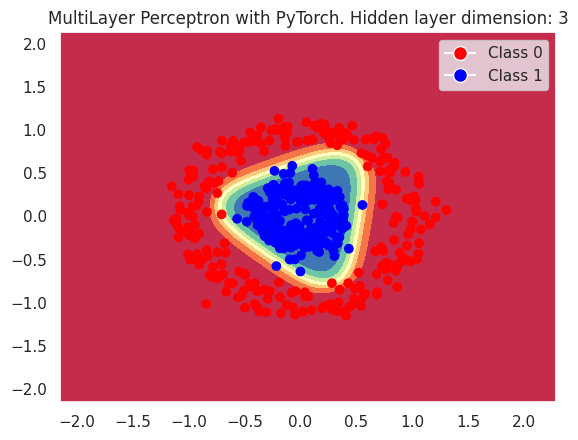

In [31]:
# Improve plots appearance
sns.set_theme()

_ = plot_decision_boundaries(
    model=model,
    x=x_train,
    y=y_train,
    title=f"MultiLayer Perceptron with PyTorch. Hidden layer dimension: {hidden_layer_dim}",
    device=device,
)
plt.show()